In [2]:
# Importing Dependencies
import tensorflow as tf
# from google.colab import drive
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from sklearn.metrics import confusion_matrix, classification_report
from skimage.color import rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import cv2

In [3]:

# Providing the Paths to the Training, Validation, and Testing data
training_path = r"C:\Users\lenovo\Desktop\Image_Recognition_for_Microplastics-main\Resources\1_Training"
validation_path = r"C:\Users\lenovo\Desktop\Image_Recognition_for_Microplastics-main\Resources\2_Validation"
testing_path = r"C:\Users\lenovo\Desktop\Image_Recognition_for_Microplastics-main\Resources\3_Testing"

# Resizing the jpgs to 128x128 to reduce processing needs and to provide uniform images
def resize_images(image):
    resized_image = resize(image.squeeze(), (128, 128))
    return np.expand_dims(resized_image, axis=-1)

# Loading the JPGs as B&W to save memory
def rgb_to_gray(image):
    return rgb2gray(image)

# Setting random seeds for Numpy & TensorFlow for reproducibility
np.random.seed(14)
tf.random.set_seed(14)

# All jpgs should be the same size (128,128)
# Rescaling in anticipation of Neural Networking modeling later in the process.
# Allowing for some variation in image orientation.
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=lambda x: resize(x.squeeze(), (128, 128)),
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

# Fitting the ImageDataGenerator onto the Training data
datagen.fit(np.zeros((1, 128, 128, 3)))

# Defining Training and Validation sets
train_generator = datagen.flow_from_directory(
    training_path,
    target_size=(128, 128),
    batch_size=1154,
    class_mode='binary',
)

validation_generator = datagen.flow_from_directory(
    validation_path,
    target_size=(128, 128),
    batch_size=208,
    class_mode='binary',
)

Found 1154 images belonging to 2 classes.
Found 208 images belonging to 2 classes.


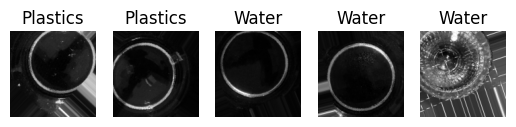

In [4]:
# Check to see what it is we loaded into the Training Set
# Loading the first batch from train_generator
batch = next(train_generator)

# Extracting the images and labels from the batch
images, labels = batch

# Updating labels for better readability
updated_labels = ["Water" if label == 0 else "Plastics" for label in labels]

# Displaying the first few images along with their labels
num_images_to_display = 5
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(images[i][:, :, 0], cmap='gray')
    plt.title(f"{updated_labels[i]}")
    plt.axis('off')

plt.show()

In [5]:
# Double checking the shape of the output from the resizing
# Even though images are Greyscale, we want to make sure that the color channels are 3, so they are compatable with MobileNetV2.
sample_batch = next(train_generator)
sample_image = sample_batch[0][0]
print("Shape after resize_images:", sample_image.shape)

Shape after resize_images: (128, 128, 3)


In [6]:
# Building the Image Classification Model, using Convolutional Neural Network, via MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freezing the convolutional base
base_model.trainable = False

# Modeling with classification head on top of MobileNetV2
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='elu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='leaky_relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

# Compiling the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,627,137 (10.02 MB)

 Trainable params: 369,153 (1.41 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
# Training the Model
epochs = 500

history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator)

# Generating Evaluation from the Training & Validation Sets
train_loss, train_accuracy = model.evaluate(train_generator)
valid_loss, valid_accuracy = model.evaluate(validation_generator)

# Displaying accuracy & loss.
print(f'Training Accuracy: {train_accuracy}')
print(f'Training Loss: {train_loss}')
print(f'----------------------------------------')
print(f'Validation Accuracy: {valid_accuracy}')
print(f'Validation Loss: {valid_loss}')

c:\Users\lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 0.5026 - loss: 1.1486 - val_accuracy: 0.5000 - val_loss: 1.4145
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.5026 - loss: 1.3500 - val_accuracy: 0.5000 - val_loss: 0.9327
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.5121 - loss: 1.0096 - val_accuracy: 0.5865 - val_loss: 0.6701
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.5217 - loss: 0.7822 - val_accuracy: 0.5000 - val_loss: 0.7310
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.5407 - loss: 0.7860 - val_accuracy: 0.5096 - val_loss: 0.7447
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.5451 - loss: 0.8152 - val_accuracy: 0.5337 - val_loss: 0.6818
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.5225 - loss: 0.7790 - val_accuracy: 0.5769 - val_loss: 0.6742
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.5529 - loss: 0.7305 - val_accuracy: 0.5000 - val_loss:

In [15]:

# Evaluating the model on the testing set
testing_generator = datagen.flow_from_directory(
    testing_path,
    target_size=(128, 128),
    batch_size=200,
    class_mode='binary',
    shuffle=True,

)

# Generating Evaluation from the testing set
test_loss, test_accuracy = model.evaluate(testing_generator)

# Displaying accuracy & loss
print(f'Testing Accuracy: {test_accuracy}')
print(f'Testing Loss: {test_loss}')

Found 200 images belonging to 2 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6350 - loss: 0.7472
Testing Accuracy: 0.6349999904632568
Testing Loss: 0.747199535369873


In [12]:
# Generating predictions on the testing set
predictions = model.predict(testing_generator)

# Converting predictions to binary values (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)

# Getting true labels from the generator
true_labels = testing_generator.classes

# Displaying confusion matrix
conf_matrix = confusion_matrix(true_labels, binary_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Displaying classification report
classification_rep = classification_report(true_labels, binary_predictions)
print("Classification Report:")
print(classification_rep)

# Displaying accuracy & loss
print(f'Testing Accuracy: {test_accuracy}')
print(f'Testing Loss: {test_loss}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Confusion Matrix:
[[25 75]
 [27 73]]
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.25      0.33       100
           1       0.49      0.73      0.59       100

    accuracy                           0.49       200
   macro avg       0.49      0.49      0.46       200
weighted avg       0.49      0.49      0.46       200

Testing Accuracy: 0.625
Testing Loss: 0.7822492718696594


In [ ]:
# Getting the predicted labels from the results
# predicted_labels = (binary_predictions > 0.5).astype(int)

# Comparing the True Labels to the Predicted Labels
print("True Labels:")
print(true_labels)
print(f'---------------------------------------------------------')
print("Testing Predicted Labels:")
print(binary_predictions.flatten())

True Labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
---------------------------------------------------------
Testing Predicted Labels:
[1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 0 0
 1 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 1 0 1 1 1
 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1]


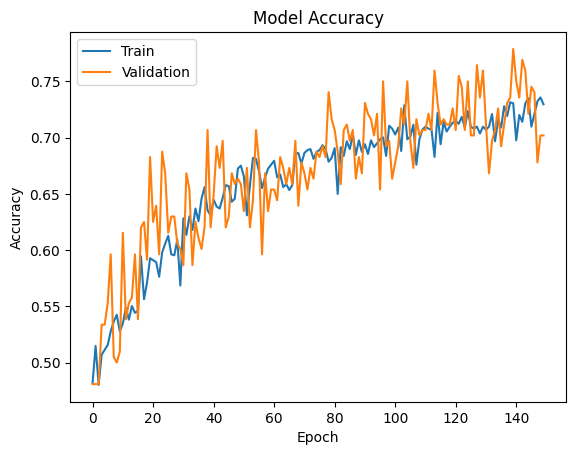

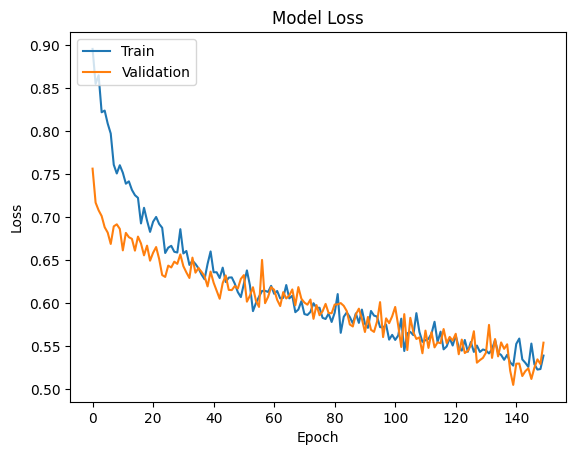

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [1]:
# ===============================
# Microplastics Detection Script
# ===============================

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

# -------------------------------
# 1️⃣ Create MobileNetV2 model
# -------------------------------
def create_model(input_shape=(224,224,3), num_classes=1):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # freeze base

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# -------------------------------
# 2️⃣ Load weights if available
# -------------------------------
def load_model_with_weights(weights_path):
    model = create_model()
    if os.path.exists(weights_path):
        try:
            model.load_weights(weights_path)
            print(f"✅ Weights loaded from {weights_path}")
        except Exception as e:
            print(f"❌ Could not load weights: {e}")
            print("⚠️ Using randomly initialized model (prediction not accurate).")
    else:
        print(f"❌ Weights file not found at {weights_path}")
        print("⚠️ Using randomly initialized model (prediction not accurate).")
    return model

# -------------------------------
# 3️⃣ Preprocess image
# -------------------------------
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224,224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

# -------------------------------
# 4️⃣ Predict microplastics
# -------------------------------
def predict_microplastic(image_path, model, threshold=0.5):
    if not os.path.exists(image_path):
        print(f"❌ Image file not found at {image_path}")
        return None, None

    img_array = preprocess_image(image_path)
    prob = model.predict(img_array, verbose=0)[0][0]

    if prob > threshold:
        label = "Microplastics"
        confidence = prob * 100
    else:
        label = "Clean Water"
        confidence = (1 - prob) * 100

    print(f"🔍 Prediction: {label}")
    print(f"📊 Confidence: {confidence:.2f}%")
    return label, confidence

# -------------------------------
# 5️⃣ Main function
# -------------------------------
def main():
    # ⚠️ Update paths here
    weights_path = r"C:\Users\lenovo\Desktop\Image_Recognition_for_Microplastics-main\MicroPystics.weights.h5"
    image_path = r"C:\Users\lenovo\Desktop\sample.jpg"

    print("🚀 Starting Microplastics Detection System...")
    print("="*50)

    model = load_model_with_weights(weights_path)
    print(f"🔍 Analyzing image: {image_path}")
    label, confidence = predict_microplastic(image_path, model)
    print("="*50)
    print("✅ Analysis complete!")

if __name__ == "__main__":
    main()


🚀 Starting Microplastics Detection System...


c:\Users\lenovo\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


❌ Could not load weights: A total of 104 objects could not be loaded. Example error message for object <Conv2D name=Conv1, built=True>:

Layer 'Conv1' expected 1 variables, but received 0 variables during loading. Expected: ['kernel']

List of objects that could not be loaded:
[<Conv2D name=Conv1, built=True>, <BatchNormalization name=bn_Conv1, built=True>, <DepthwiseConv2D name=expanded_conv_depthwise, built=True>, <BatchNormalization name=expanded_conv_depthwise_BN, built=True>, <Conv2D name=expanded_conv_project, built=True>, <BatchNormalization name=expanded_conv_project_BN, built=True>, <Conv2D name=block_1_expand, built=True>, <BatchNormalization name=block_1_expand_BN, built=True>, <DepthwiseConv2D name=block_1_depthwise, built=True>, <BatchNormalization name=block_1_depthwise_BN, built=True>, <Conv2D name=block_1_project, built=True>, <BatchNormalization name=block_1_project_BN, built=True>, <Conv2D name=block_2_expand, built=True>, <BatchNormalization name=block_2_expand_BN, b

In [ ]:
# Saving as H5 file for Interactive Model
model.save_weights('MicroPystics.weights.h5')

In [ ]:
# Saving as TF file for Interactive Model (on mac)
model.save("./drive/MyDrive/P4_MicroPystics/MicroPystics.h5")

In [ ]:
# Testing alternative activation functions to find best candidates

# Creating activation list
activation_functions = ['leaky_relu', 'elu', 'tanh', 'selu', 'sigmoid', 'relu']

# Creating a dictionary to hold the activation function accuracy results
results = {}

# For-Looping the activation functions through the model
for activation in activation_functions:
    print(f"Training model with activation: {activation}")

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation=activation),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Training the model
    history = model.fit(train_generator, epochs=50, validation_data=validation_generator)

    # Pulling the results
    results[activation] = history.history['val_accuracy']

# Plotting the results
plt.figure(figsize=(10, 6))

Training model with activation: leaky_relu


NameError: name 'base_model' is not defined

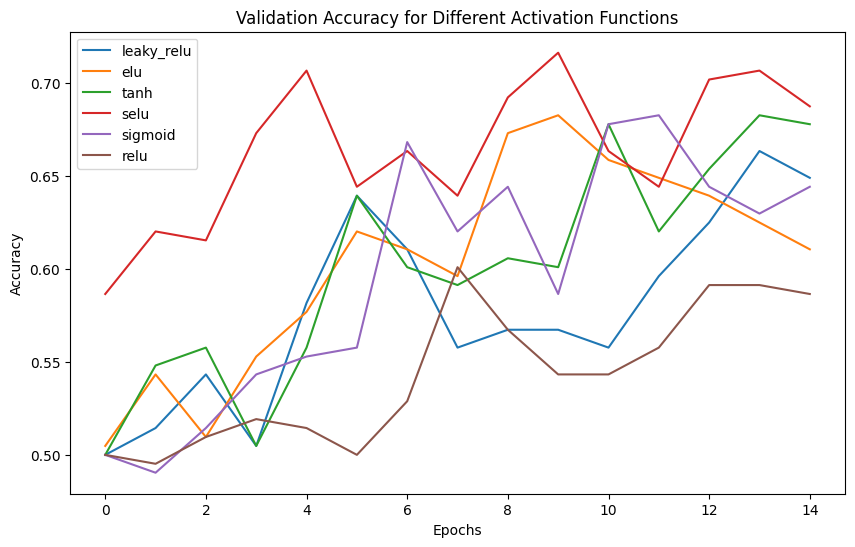

In [ ]:
# Plot the results
plt.figure(figsize=(10, 6))
for activation, accuracy in results.items():
    plt.plot(accuracy, label=activation)

plt.title('Validation Accuracy for Different Activation Functions')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()